In [302]:
import numpy as np
import matplotlib.pyplot as plt

pi = np.pi

In [303]:
# Exercise 8.42
def sampling(f, n):
    """
    Parameters:
        f (lambda function): function to sample on [0, 1)]
        n (int): 2**n is number of sample points
    Return:
        ndarray of f at points k/2^n for k in {0, ..., 2^n - 1}
    """

    # k values
    k = np.arange(2**n)
    
    # x = k/2^n values
    x = k/2**n
    
    return f(x)

def haar_wavelets(a, t):
    """
    Parameters:
        a (ndarray): array of coefficients
        t (float in [0, 1)): value in domain
    Return:
        Sum(k=0 to 2^n - 1, a_k * son(n, k)(t))
        i.e. value of the Haar son corresponding to the interval where t is
    """

    # 2^n
    num_pts = len(a)

    # floor(2^n * t) gets k index of each point
    k = np.floor(num_pts * t).astype(int)
    
    return a[k]

In [304]:
def FWT(a, j=0):
    '''Haar FWT of sample a down to level j.'''

    m = int(np.log2(len(a)))

    # Ensure length of a is a power of 2
    if m != np.log2(len(a)):
        raise ValueError('length of a is not a power of 2')
    
    # List of partial transforms
    L = list()

    while m > j:
        L.append(0.5 * (a[::2] - a[1::2]))
        a = 0.5 * (a[::2] + a[1::2])
        m -= 1
    
    return np.concatenate([a, np.concatenate(L[::-1])])

FWT(np.array([2, 0.8, 3.1, -2]), 0)
FWT(np.array([-2,4,2,-3]), 0)
FWT(np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]))

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Question 8.45

Complete the following:

1.  Code up a function that takes as input the wavelet transform (given by the array $[a_{00}, b_{00}, b_{10}, b_{11},\dots]$) and an integer $j$ and returns the approximation $T_{j}[f]\in V_j$ and detail $g_j\in V_{j}^{\perp}$ as callable functions.

2. Apply your code to the function (8.57) and reporduce the images in Figure 8.20.
    1. Note: function 8.57: $f(t) = 100t^2(1-t)|\sin(10t/3)|$

In [305]:
def daughter(j, k, t):
        '''The value of daughter_j,k at t'''

        # 1 if daughter is non-zero at t, 0 otherwise
        nonzero_or_zero = np.array((k <= 2**j * t) & (2**j * t < k+1)).astype(int)

        # 1 if daughter is 1 at t, -1 otherwise
        one_or_n_one = np.array((k <= 2**j * t) & (2**j * t < k+1/2)).astype(int)*2 - 1

        # Multiply together to get whether 1, -1, or 0 at t
        return nonzero_or_zero * one_or_n_one

def approx_detail(a, i=0):
    '''Return T_i[f] in V_i and g_i in V_i perp as callable functions.
    
    Parameters:
        a ((,) ndarray): coefficients of wavelet transform [a00, b00, b10, b11, ...]
        j (int)

    Return:
        T_i[f] approximation (function)
        g_i detail (function)
    '''
    j = np.log2(len(a)).astype(int)

    # The (m,k) tuples for the wavelet basis daughters
    approx_mk = [(m, k) for m in range(i) for k in range(2**m)]
    detail_mk = [(m, k) for m in range(i, j) for k in range(2**m)]

    # The approximation
    def approx(t):
        return np.full(len(t), a[0]) if i==0 else a[0] + np.array([a[k+1]*daughter(*mk, t) for k, mk in enumerate(approx_mk)]).sum(axis=0)
    
    # The detail
    def detail(t):
        return np.full(len(t), 0) if i==j else np.array([a[k+2**(i)]*daughter(*mk, t) for k, mk in enumerate(detail_mk)]).sum(axis=0)
    
    return approx, detail
    

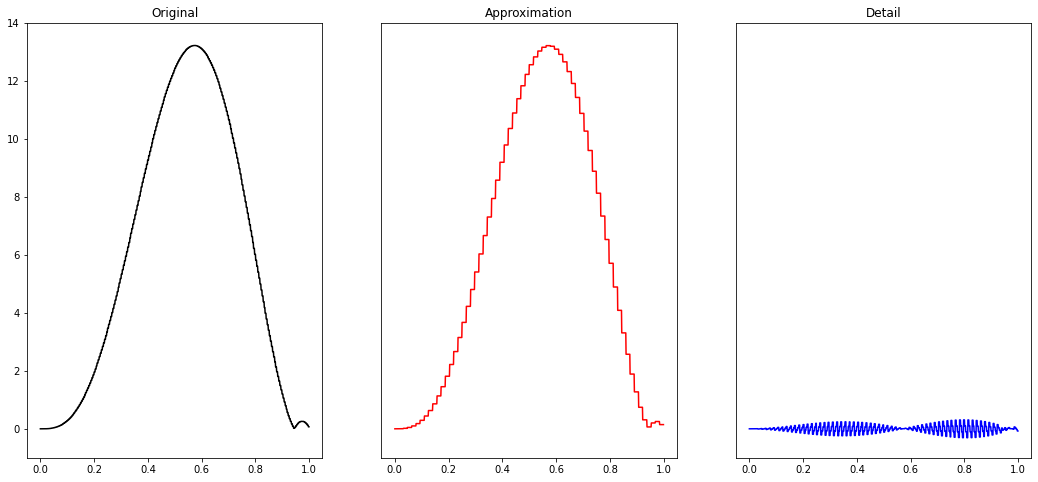

In [306]:
# Init function f, linspace x, subplots, and choose y window limits
f = lambda t: 100*t**2 * (1-t) * np.abs(np.sin(10*t/3))
x = np.linspace(0, 1, 1000, endpoint=False)
fig, axs = plt.subplots(1, 3, figsize=(18, 8))
ylim = (-1, 14)

# Init approx and detail with j, i parameters
j = 8
i = 6
a = FWT(sampling(f, j))
approx, detail = approx_detail(a, i)

# Plot T_8 son approximation as in equation 8.56
axs[0].plot(x, haar_wavelets(sampling(f, j), x), color='black')
axs[0].set_title('Original')
axs[0].set_ylim(ylim)

# Plot v6 approximation
axs[1].plot(x, approx(x), color='red')
axs[1].set_title('Approximation')
axs[1].set_ylim(ylim)
axs[1].tick_params(axis='y', which='both', left=False, labelleft=False)

# Plot g6 detail
axs[2].plot(x, detail(x), color='blue')
axs[2].set_title('Detail')
axs[2].set_ylim(ylim)
axs[2].tick_params(axis='y', which='both', left=False, labelleft=False)

# Show
plt.show()

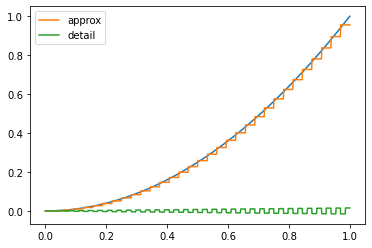

In [307]:
# My own testing
j = 6
i = 5

f = lambda t: t**2
a = FWT(sampling(f, j))

approx, detail = approx_detail(a, i)

x = np.linspace(0, 1, 1000, endpoint=False)

plt.plot(x, f(x))
plt.plot(x, approx(x), label='approx')
plt.plot(x, detail(x), label='detail')

plt.legend()
plt.show()

# Question 8.46

Complete the following:

1. Use your code from Exercise 8.42 and Exercise 8.45 to construct a method that takes a function $f$ defined on $[0,1)$, a positive integer $\ell$ and a positive integer $j < \ell$, samples $f$ to get an approximation $f_l$, and returns the two functions $T_j[f]\in V_j$ and $g_j\in V_j^{\perp}$ such that $f_{\ell} = T_j[f]+ g_j$.

2. Apply your methods to the function (8.99) for $\ell = 10$. For each value of $j \in \{0, 1, \dots, \ell - 1 \}$ plot each of the functions $T_j[f]$ and $g_j$.
    1. Note: function 8.99: $f(t) = \frac{\sin(2\pi t-5)}{\sqrt{|t-\pi/20|}}$

3. Compare the plots of each $T_j[f]$ to the corresponding plots in Exercise 8.42. In both cases they are functions in $V_j$, but they are not identical. Explain the difference. Explain why it occurs.

In [308]:
def complete_approx_detail(f, j, i):
    '''Sample f and return T_i[f] in V_i and g_i in V_i perp as callable functions.
    
    Parameters:
        f (function): function to sample
        j (int): 2**j is number of samples
        i (int < j): level of approximation and detail
    Return:
        approximation of f at level i (function)
        detail of f at level i (function)
    '''

    # Get coefficients
    a = FWT(sampling(f, j))

    # Return approximation and detail at level i
    return approx_detail(a, i)


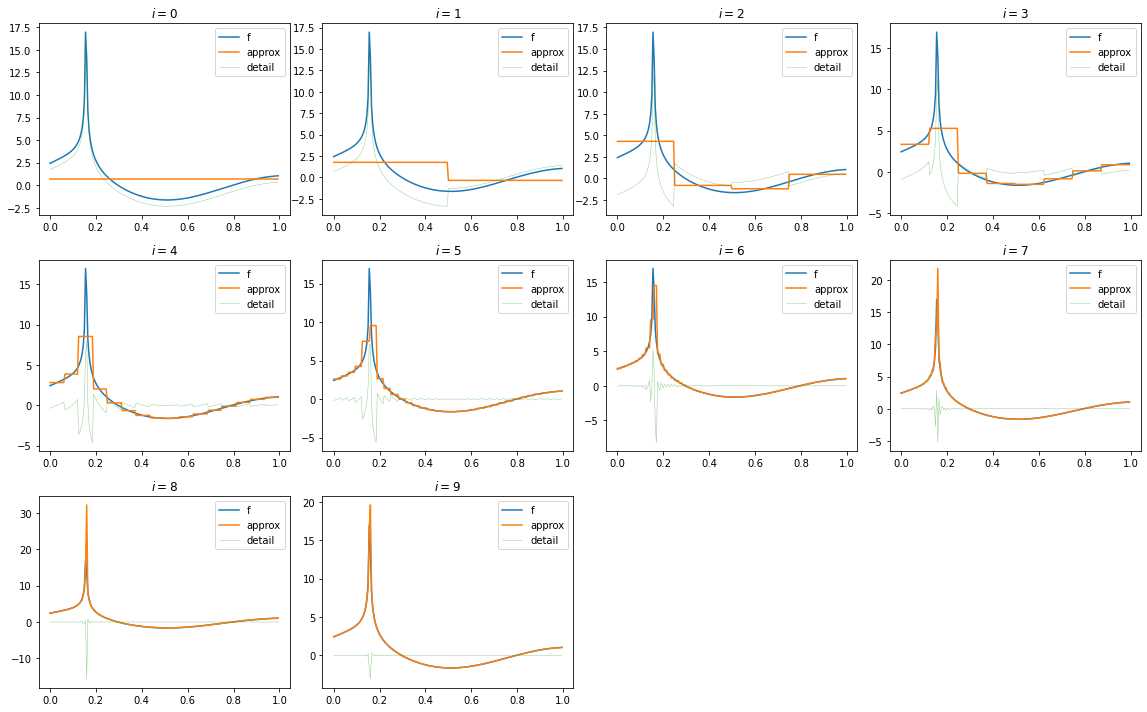

In [309]:
# f and j
f = lambda t : np.sin(2*pi*t - 5)/np.sqrt(abs(t - pi/20))
j = 10

# Create plot
fig, axs = plt.subplots(3, 4, figsize=(16, 10))
axs = np.ravel(axs)

# Create linspace
x = np.linspace(0, 1, 200, endpoint=False)

for i, ax in zip(range(j), axs):
    # Get approximation and detail
    approx, detail = complete_approx_detail(f, j, i)

    # Plot f and level i approximation and detail of f
    ax.plot(x, f(x), label='f')
    ax.plot(x, approx(x), label='approx')
    ax.plot(x, detail(x), label='detail', lw=0.5, alpha=0.5)
    
    # Plot properties
    ax.legend()
    ax.set_title(f'$i = {{{i}}}$')

# Delete extra axs
[plt.delaxes(ax) for ax in axs[-2:]]

# Plot
plt.tight_layout()
plt.show()

In the plots in Exercise 8.42, the approximation matches the original function at each $x=k/2^j$, while in these plots they do not.

This is because the approximations in Exercise 8.42 consisted only of sons, while the approximations in this exercise consist of the father and varying numbers of daughters.

# Question 8.47

Complete the following:

1. Adapt your code from the previous problem to sample functions on any compat interval $[a,b]$, construct the Haar wavelet transform of the sampled function on that interval, and return the two functions $T_j[f]\in V_j$ and $g_j\in V_{j}^{\perp}$ such that $f_{\ell} = T_j[f] +g_j$

2. Apply your method to the function (8.99) on the interval $[-1,1]$ for $\ell=10$. For each value of $j\in \{0,1, \dots, \ell - 1\}$ plot each of the funcitons $T_j[f]$ and $g_j$.

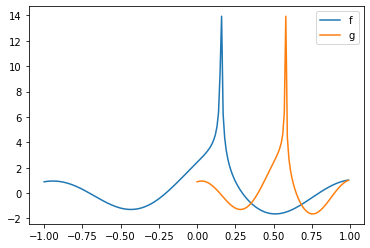

In [310]:
# My own testing for scaling and translating functions
a, b = -1, 1
x = np.linspace(a, b, 200, endpoint=False)
y = np.linspace(0, 1, 100, endpoint=False)

f = lambda t : np.sin(2*pi*t - 5)/np.sqrt(abs(t - pi/20))
g = lambda t: f((b-a)*t + a)

plt.plot(x, f(x), label='f')
plt.plot(y, g(y), label='g')

plt.legend()
plt.show()

In [311]:
def interval_complete_approx_detail(c, d, f, j, i):
    '''Sample f and return T_i[f] in V_i and g_i in V_i perp as callable functions.
    Allow any compact interval [c, d].
    
    Parameters:
        c, d (ints): compact interval [c, d] on which f is defined 
        f (function): function to sample
        j (int): 2**j is number of samples
        i (int < j): level of approximation and detail
    Return:
        approximation of f at level i (function)
        detail of f at level i (function)
    '''

    # Check if c and d are equal
    if c==d: raise ValueError('a and b are equal')

    # Scale and translate f to [0, 1]
    g = lambda t: f((d-c)*t + c)
    
    # Get approximation and detail of g
    a = FWT(sampling(g, j))
    approx, detail = approx_detail(a, i)

    # Scale and translate approximation and detail to [a, b]
    return lambda t: approx((t-c)/(d-c)), lambda t: detail((t-c)/(d-c))


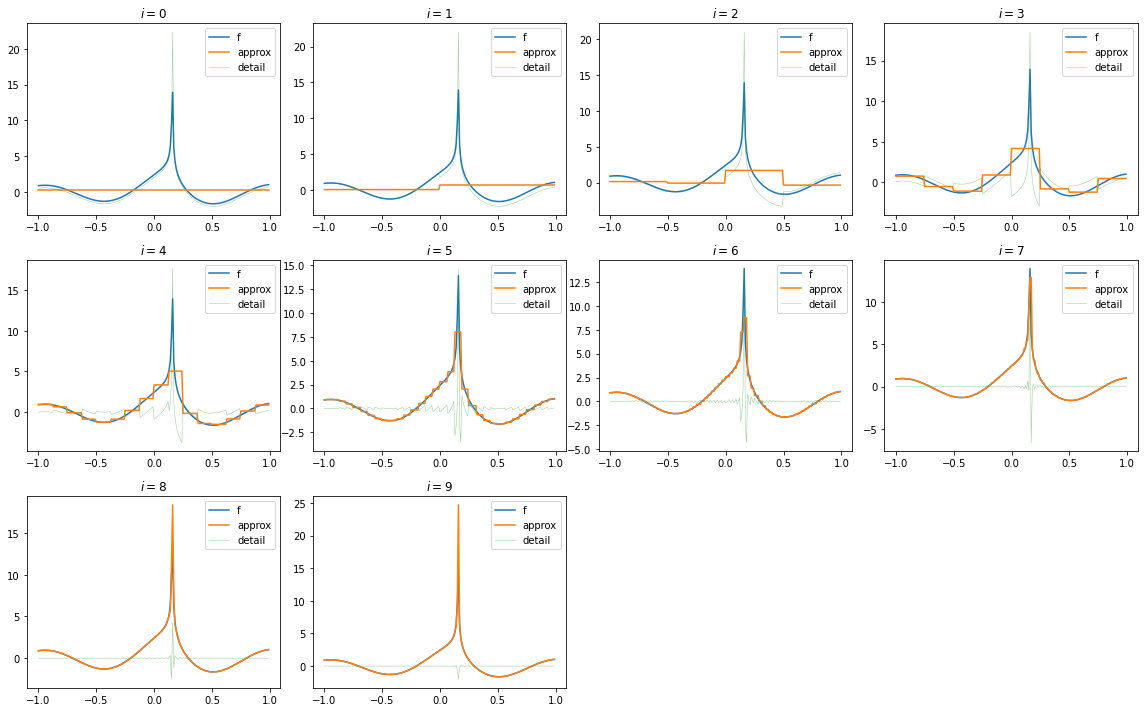

In [312]:
# f, interval [a, b], and j
f = lambda t : np.sin(2*pi*t - 5)/np.sqrt(abs(t - pi/20))
interval = (-1, 1)
j = 10

# Create plot
fig, axs = plt.subplots(3, 4, figsize=(16, 10))
axs = np.ravel(axs)

# Create linspace
x = np.linspace(*interval, 200, endpoint=False)

for i, ax in zip(range(j), axs):
    # Get approx and detail
    approx, detail = interval_complete_approx_detail(*interval, f, j, i)

    # Plot f and level i approximation and detail of f
    ax.plot(x, f(x), label='f')
    ax.plot(x, approx(x), label='approx')
    ax.plot(x, detail(x), label='detail', lw=0.5, alpha=0.5)
    
    # Plot properties
    ax.legend()
    ax.set_title(f'$i = {{{i}}}$')

# Delete extra axs
[plt.delaxes(ax) for ax in axs[-2:]]

# Plot
plt.tight_layout()
plt.show()